In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import sys
import rich
import pickle
import os
from pathlib import Path

# source /home/phbelang/abp/BBStudies/Executables/py_BB/bin/activate
if 'BBStudies/Executables/py_BB/bin' not in os.environ.get('PATH').split(':')[0]:
    raise Exception('Wrong Python Distribution, use BBStudies/Executables/py_BB')


import xobjects as xo
import xtrack as xt
import xpart as xp
import xfields as xf

sys.path.append('/home/phbelang/abp/BBStudies/')
# sys.path.append('/home/pbelanger/ABPlocal/BBStudies')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as dtune
import BBStudies.Physics.Base as phys
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Constants as cst


LINEFOLDER = './Lines/'
def import_from_lines(line_ID,to_track):
    line   = {}
    twiss  = {}
    survey = {}

    for seq in ['lhcb1','lhcb4']:
        _beam = seq[-2:]
        # Importing Line
        line[_beam] = xPlus.importLine(LINEFOLDER + f'line_{line_ID}_{seq}.json')
        
        # Importing twiss and tracker
        if _beam == 'b1':
            tracker_b1    = xt.Tracker(line=line[_beam])
            twiss[_beam]  = tracker_b1.twiss().to_pandas(index="name")
            survey[_beam] = tracker_b1.survey().to_pandas(index="name")
        elif _beam == 'b4':
            tracker_b4    = xt.Tracker(line=line[_beam])
            twiss[_beam]   = tracker_b4.twiss().to_pandas(index="name")
            survey[_beam]  = tracker_b4.survey().to_pandas(index="name")

            _beam = 'b2'
            twiss[_beam]   = tracker_b4.twiss().reverse().to_pandas(index="name")
            survey[_beam]  = tracker_b4.survey().reverse().to_pandas(index="name")


    if to_track == 'b1':
        tracker = tracker_b1
        del tracker_b4
    else:
        tracker = tracker_b4
        del tracker_b1
    # Clearing xsuite ouput
    clear_output(wait=False)



    allVars = list(tracker.vars._owner.keys())
    allElements = list(tracker.element_refs._owner.keys())


    # Deactivating all wires
    #===================================================
    tracker.vars['enable_qff'] = 0
    for IP in ['ip1','ip5']:
        tracker.vars[f"bbcw_rw_{IP}.{_beam}"] = 1
        tracker.vars[f"bbcw_i_{IP}.{_beam}"]  = 0
    run3_wires = [name for name in allElements if ('bbcw' in name)&('wire' in name)]
    for wire in run3_wires:
        tracker.line.element_dict[wire].post_subtract_px  = 0
        tracker.line.element_dict[wire].post_subtract_py  = 0
        
    # Creating BB knobs
    #===================================================
    
    for _ip in ['ip1','ip5','ip2','ip8']:
        bb_lr = [name for name in allElements if ('bb_lr' in name)&(f'{_ip[-1]}{_beam}' in name)]
        bb_ho = [name for name in allElements if ('bb_ho' in name)&(f'{_ip[-1]}{_beam}' in name)]

        # New knob:
        tracker.vars[f'{_ip}_bblr_ON'] = 1
        tracker.vars[f'{_ip}_bbho_ON'] = 1

        # Linking to new knob 
        for _lr in bb_lr:
            # Infividual knobs
            tracker.vars[f'{_lr}_ON'] = 1
            tracker.element_refs[_lr].scale_strength = tracker.vars[f'{_lr}_ON']*tracker.vars[f'{_ip}_bblr_ON']*tracker.element_refs[_lr].scale_strength._value

        for _ho in bb_ho:
            tracker.element_refs[_ho].scale_strength = tracker.vars[f'{_ip}_bbho_ON']*tracker.element_refs[_ho].scale_strength._value

    # Creating sext and oct knobs
    #====================================================

    # AS DONE IN THE MASK
    #---------------------
    part = tracker.line.particle_ref
    brho = part.p0c[0]/(part.q0*cst.c)
    tracker.vars['I_oct'] = 0
    for ss in '12 23 34 45 56 67 78 81'.split():
        tracker.vars[f'kof.a{ss}{_beam}'] = tracker.vars['kmax_mo']*tracker.vars['I_oct']/tracker.vars['imax_mo']/brho
        tracker.vars[f'kod.a{ss}{_beam}'] = tracker.vars['kmax_mo']*tracker.vars['I_oct']/tracker.vars['imax_mo']/brho
    #---------------------

    
    ks = [name for name in allVars if ('ksf' in name)|('ksd' in name)]
    ko = [name for name in allVars if ('kof.a' in name)|('kod.a' in name)]

    tracker.vars['all_oct_ON']  = 1
    tracker.vars['all_sext_ON'] = 1
    for _ks in ks:
        if tracker.vars[_ks]._expr is None:
            tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._value
        else:
            tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._expr 
    for _ko in ko:
        if tracker.vars[_ko]._expr is None:
            tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._value
        else:
            tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._expr 

    return tracker,line,twiss,survey

import yaml
def import_IP_config(line_ID,twiss,survey):
    # Loading config
    #============================

    with open(LINEFOLDER+f'../Configs/config_{line_ID}.yaml','r') as fid:
        configuration = yaml.safe_load(fid)




    B1 = inp.Beam('b1',twiss['b1'],survey['b1'],
                Nb       = float(configuration['beam_npart']),
                E        = float(configuration['beam_energy_tot'])*1e9,
                emittx_n = configuration['beam_norm_emit_x']*1e-6,
                emitty_n = configuration['beam_norm_emit_y']*1e-6,
                dp_p0    = 0)
        
    B2 = inp.Beam('b2',twiss['b2'],survey['b2'],
                Nb       = float(configuration['beam_npart']),
                E        = float(configuration['beam_energy_tot'])*1e9,
                emittx_n = configuration['beam_norm_emit_x']*1e-6,
                emitty_n = configuration['beam_norm_emit_y']*1e-6,
                dp_p0    = 0)

    IP1 = inp.InteractionPoint('ip1',B1,B2)
    IP5 = inp.InteractionPoint('ip5',B1,B2)

    return IP1,IP5

def generate_particles(tracker,B1,B2,to_track,method='6d',contour = False):
    
    BEAM = {'b1':B1,'b4':B2}[to_track]
    # Generating Coord grid
    #=========================================================
    coordinates = phys.polar_grid(  r_sig     = np.array([1e-6] + list(np.linspace(1,6.5,23))),
                                    theta_sig = np.linspace(0.02*np.pi/2,0.98*np.pi/2,17),
                                    emitt     = [BEAM.emittx,BEAM.emitty])
    coordinates.insert(0,'delta',0)

    if contour:
        ctour_idx  = list(coordinates[coordinates['theta_sig'] == np.min(coordinates['theta_sig'])].index)
        ctour_idx += list(coordinates[coordinates['r_sig'] == np.max(coordinates['r_sig'])].index)[1:-1]
        ctour_idx += list(coordinates[coordinates['theta_sig'] == np.max(coordinates['theta_sig'])].index)[::-1]
        ctour_idx += list(coordinates[coordinates['r_sig'] == np.min(coordinates['r_sig'])].index)[1:-1][::-1]

        coordinates = coordinates.loc[ctour_idx]

    group_length = len(coordinates)

    # Generation
    p0        = xp.Particles(mass0=tracker.line.particle_ref.mass0, q0 = tracker.line.particle_ref.q0 , p0c=tracker.line.particle_ref.p0c)
    particles = xp.build_particles( method       = method,
                                    particle_ref = p0,
                                    tracker      = tracker,
                                    x_norm       = coordinates['x_sig'].values, 
                                    px_norm      = None, 
                                    y_norm       = coordinates['y_sig'].values, 
                                    py_norm      = None,
                                    zeta         = None,
                                    delta        = coordinates['delta'].values,
                scale_with_transverse_norm_emitt = [BEAM.emittx_n,BEAM.emitty_n])
    
    return particles,coordinates


def match_tracker(tracker,to_track):
    if to_track == 'b4':
        to_track = 'b2'
    # Matching
    #===================================
    for _ip in ['ip1','ip5','ip2','ip8']:
        tracker.vars[f'{_ip}_bblr_ON'] = 0
        tracker.vars[f'{_ip}_bbho_ON'] = 0

    tracker.vars['all_oct_ON']   = 1
    tracker.vars['all_sext_ON']  = 1

    tw_final = tracker.twiss()
    Qx_0,Qy_0 = np.round(np.mod(tw_final['qx'],1),4),np.round(np.mod(tw_final['qy'],1),4)
    print('\nInitial twiss parameters')
    print(f"Qx = {tw_final['qx']:.5f} Qy = {tw_final['qy']:.5f} "
        f"Q'x = {tw_final['dqx']:.5f} Q'y = {tw_final['dqy']:.5f}")
    print(40*'-')

    try:
        tracker.match(vary=[f'dqx.{to_track}',f'dqy.{to_track}'],
            targets = [
                ('qx', 62.31),
                ('qy', 60.32)])
                
        tracker.match(vary=[f'dqpx.{to_track}_sq',f'dqpy.{to_track}_sq'],
            targets = [
                ('dqx', 15.0),
                ('dqy', 15.0)])
    except RuntimeError:
        print('Matching didnt find an improvement')





    tw_final = tracker.twiss()
    Qx_0,Qy_0 = np.round(np.mod(tw_final['qx'],1),4),np.round(np.mod(tw_final['qy'],1),4)
    print('\nFinal twiss parameters')
    print(f"Qx = {tw_final['qx']:.5f} Qy = {tw_final['qy']:.5f} "
        f"Q'x = {tw_final['dqx']:.5f} Q'y = {tw_final['dqy']:.5f}")
    #===================================



# line_ID    = 'ID05_t0'
# to_track   = 'b4'


# # Importing and Filtering twiss
# #====================================
# tracker,line,twiss,survey = import_from_lines(line_ID,to_track)
# twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
# twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..','bbcw'])
# #====================================

# # Importing IP Objects
# #====================================
# IP1,IP5 = import_IP_config(line_ID,twiss,survey)
# #====================================



---
# Coordinates
---

(-0.3248395991375657, 6.82163227292558, -0.3248395991375657, 6.82163227292558)

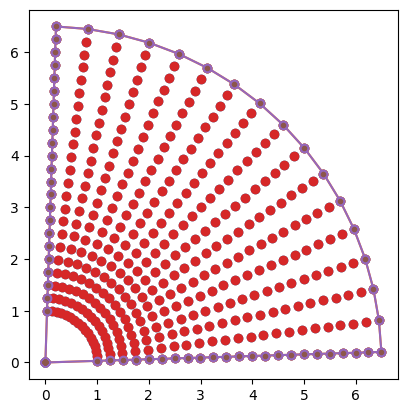

In [14]:
particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=False)


plt.figure()
particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=False)
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'o')
particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=True)
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'-o')
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'.')


plt.axis('square')
# plt.xlim([0,1.5])
# plt.ylim([0,1.5])

---
# TRACKING
---

In [2]:

to_track = 'b4'
CONTOUR  = False
OUTFOLDER = './Tracking'
# for line_ID in ['base',
#                 'emitt_01',
#                 'emitt_02',
#                 'emitt_03',
#                 'emitt_04',
#                 'xing_01',
#                 'xing_02',
#                 'xing_03',
#                 'xing_04']:
for line_ID in ['emitt_01',
                'emitt_02',
                'emitt_03',
                'emitt_04']:

# for line_ID in ['base']:
    # Importing and Filtering twiss
    #====================================
    tracker,line,twiss,survey = import_from_lines(line_ID,to_track)
    twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
    twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..'])
    #====================================
    
    # Importing IP Objects
    #====================================
    IP1,IP5 = import_IP_config(line_ID,twiss,survey)
    #====================================
    
    # Fixing emittance
    IP1.b2.emittx_n = 2.3e-6
    IP1.b2.emitty_n = 2.3e-6
    line_ID         = line_ID.replace('emitt','base_strong')

    # Matching
    #====================================
    match_tracker(tracker,to_track)
    #====================================

    # REFERENCE
    #==========================
    tracker.vars[f'ip1_bbho_ON'] = 0
    tracker.vars[f'ip5_bbho_ON'] = 0

    tracker.vars[f'ip1_bblr_ON'] = 0
    tracker.vars[f'ip5_bblr_ON'] = 0

    tracker.vars['all_oct_ON']   = 0
    tracker.vars['all_sext_ON']  = 1
    #==========================

    particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
    particles.zeta  *= 0
    particles.delta *= 0
    tracked_ref = xPlus.Tracking(tracker, particles, n_turns = 1024,method='4D',progress=True)
    tracked_ref.to_pickle(f'{OUTFOLDER}/tracked_ref_sf10_{line_ID}.pkl')
    coordinates[['r_sig','theta_sig','x_sig','y_sig']].to_pickle(f'{OUTFOLDER}/coordinates_{line_ID}.pkl')

    # Choosing knobs
    #==========================
    tracker.vars[f'ip1_bbho_ON'] = 1/10
    tracker.vars[f'ip5_bbho_ON'] = 1/10

    tracker.vars[f'ip1_bblr_ON'] = 0
    tracker.vars[f'ip5_bblr_ON'] = 0

    tracker.vars['all_oct_ON']   = 0
    tracker.vars['all_sext_ON']  = 1
    #==========================

    _cp_emittx_n = float(IP1.b2.emittx_n)
    _cp_emitty_n = float(IP1.b2.emitty_n)
    particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
    particles.zeta  *= 0
    particles.delta *= 0
    tracked_HO = xPlus.Tracking(tracker, particles, n_turns = 1024,method='4D',progress=True)
    tracked_HO.to_pickle(f'{OUTFOLDER}/tracked_HO_sf10_{line_ID}.pkl')

    IP1.b2.emittx_n = 2.3e-6
    IP1.b2.emitty_n = 2.3e-6
    particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
    particles.zeta  *= 0
    particles.delta *= 0
    tracked_HO = xPlus.Tracking(tracker, particles, n_turns = 1024,method='4D',progress=True)
    tracked_HO.to_pickle(f'{OUTFOLDER}/tracked_HO_sf10_{line_ID}_frz23.pkl')
    IP1.b2.emittx_n = _cp_emittx_n 
    IP1.b2.emitty_n = _cp_emitty_n 

    # Choosing knobs
    #==========================
    tracker.vars[f'ip1_bbho_ON'] = 0
    tracker.vars[f'ip5_bbho_ON'] = 0

    tracker.vars[f'ip1_bblr_ON'] = 1/10
    tracker.vars[f'ip5_bblr_ON'] = 1/10

    tracker.vars['all_oct_ON']   = 0
    tracker.vars['all_sext_ON']  = 1
    #==========================


    particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
    particles.zeta *= 0
    particles.delta *= 0
    tracked_LR = xPlus.Tracking(tracker, particles, n_turns = 1024,method='4D',progress=True)
    tracked_LR.to_pickle(f'{OUTFOLDER}/tracked_LR_sf10_{line_ID}.pkl')


    IP1.b2.emittx_n = 2.3e-6
    IP1.b2.emitty_n = 2.3e-6
    particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
    particles.zeta  *= 0
    particles.delta *= 0
    tracked_LR = xPlus.Tracking(tracker, particles, n_turns = 1024,method='4D',progress=True)
    tracked_LR.to_pickle(f'{OUTFOLDER}/tracked_LR_sf10_{line_ID}_frz23.pkl')
    IP1.b2.emittx_n = _cp_emittx_n 
    IP1.b2.emitty_n = _cp_emitty_n 


     # Choosing knobs
    #==========================
    tracker.vars[f'ip1_bbho_ON'] = 0
    tracker.vars[f'ip5_bbho_ON'] = 0

    tracker.vars[f'ip1_bblr_ON'] = 0
    tracker.vars[f'ip5_bblr_ON'] = 0

    tracker.vars['all_oct_ON']   = 1
    tracker.vars['all_sext_ON']  = 1

    I_oct = 430
    tracker.vars['I_oct'] = I_oct/10
    #==========================


    particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
    particles.zeta  *= 0
    particles.delta *= 0
    tracked_OCTU = xPlus.Tracking(tracker, particles, n_turns = 1024,method='4D',progress=True)
    tracked_OCTU.to_pickle(f'{OUTFOLDER}/tracked_OCTU_sf10_{line_ID}.pkl')


     # Choosing knobs
    #==========================
    tracker.vars[f'ip1_bbho_ON'] = 0
    tracker.vars[f'ip5_bbho_ON'] = 0

    tracker.vars[f'ip1_bblr_ON'] = 0
    tracker.vars[f'ip5_bblr_ON'] = 0

    tracker.vars['I_oct'] = 0
    tracker.vars['all_oct_ON']   = 0
    tracker.vars['all_sext_ON']  = 1
    
   
    p0 = xp.Particles(mass0=tracker.line.particle_ref.mass0, q0 = tracker.line.particle_ref.q0 , p0c=tracker.line.particle_ref.p0c)
    particle_on_tracker_co = tracker.find_closed_orbit(particle_co_guess=p0)

    tracker.vars['enable_qff'] = 1

    _beam_el = {'b1':'b1','b4':'b2'}[to_track]
    tracker.vars[f"bbcw_rw_ip5.{_beam_el}"] = (18.85/2+3)*1e-3
    tracker.vars[f"bbcw_i_ip5.{_beam_el}"]  = 350/10

    # fixed to 12.4 instead of 12.3 to get 8.5 sig collimator at emitt=3.5e-6
    tracker.vars[f"bbcw_rw_ip1.{_beam_el}"] = (12.40/2+3)*1e-3
    tracker.vars[f"bbcw_i_ip1.{_beam_el}"]  = 350/10
    #==========================
    
    xf.configure_orbit_dependent_parameters_for_bb(tracker,particle_on_co=particle_on_tracker_co)

    particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
    particles.zeta  *= 0
    particles.delta *= 0
    tracked_BBCW = xPlus.Tracking(tracker, particles, n_turns = 1024,method='4D',progress=True)
    tracked_BBCW.to_pickle(f'{OUTFOLDER}/tracked_BBCW_sf10_{line_ID}.pkl')





Initial twiss parameters
Qx = 62.31001 Qy = 60.32001 Q'x = 14.98486 Q'y = 15.00366
----------------------------------------
Matching didnt find an improvement

Final twiss parameters
Qx = 62.31001 Qy = 60.32001 Q'x = 14.98486 Q'y = 15.00366
generating ./c3f190d592534e15b7964401ebdd4a3d.c
the current directory is '/eos/user/p/phbelang/Programming/FPCatalogue'
running build_ext
building 'c3f190d592534e15b7964401ebdd4a3d' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c c3f190d592534e15b7964401ebdd4a3d.c -o ./c3f190d592534e15b7964401ebdd4a3d.o -

Output()

generating ./76935b3aaa01435a935a058c9aa49a16.c
the current directory is '/eos/user/p/phbelang/Programming/FPCatalogue'
running build_ext
building '76935b3aaa01435a935a058c9aa49a16' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c 76935b3aaa01435a935a058c9aa49a16.c -o ./76935b3aaa01435a935a058c9aa49a16.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executa

Output()

generating ./cb93402d4ddd4e329893b76d6364226b.c
the current directory is '/eos/user/p/phbelang/Programming/FPCatalogue'
running build_ext
building 'cb93402d4ddd4e329893b76d6364226b' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c cb93402d4ddd4e329893b76d6364226b.c -o ./cb93402d4ddd4e329893b76d6364226b.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executa

Output()

generating ./9253a507fc174e77b136a68082488a2a.c
the current directory is '/eos/user/p/phbelang/Programming/FPCatalogue'
running build_ext
building '9253a507fc174e77b136a68082488a2a' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c 9253a507fc174e77b136a68082488a2a.c -o ./9253a507fc174e77b136a68082488a2a.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executa

Output()

In [2]:

to_track = 'b4'
CONTOUR  = False
OUTFOLDER = './Tracking'
# for line_ID in ['base',
#                 'emitt_01',
#                 'emitt_02',
#                 'emitt_03',
#                 'emitt_04',
#                 'xing_01',
#                 'xing_02',
#                 'xing_03',
#                 'xing_04']:
for line_ID,weak_emit,l_ID in zip(['base','base','base', 'base'],[1.9,2.1,2.3,2.5],['01','02','03','04']):

# for line_ID in ['base']:
    # Importing and Filtering twiss
    #====================================
    tracker,line,twiss,survey = import_from_lines(line_ID,to_track)
    twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
    twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..'])
    #====================================
    
    # Importing IP Objects
    #====================================
    IP1,IP5 = import_IP_config(line_ID,twiss,survey)
    #====================================
    
    # Fixing emittance
    IP1.b2.emittx_n = weak_emit*1e-6
    IP1.b2.emitty_n = weak_emit*1e-6
    line_ID         = line_ID.replace('base',f'base_weak_{l_ID}')

    # Matching
    #====================================
    match_tracker(tracker,to_track)
    #====================================

    # REFERENCE
    #==========================
    tracker.vars[f'ip1_bbho_ON'] = 0
    tracker.vars[f'ip5_bbho_ON'] = 0

    tracker.vars[f'ip1_bblr_ON'] = 0
    tracker.vars[f'ip5_bblr_ON'] = 0

    tracker.vars['all_oct_ON']   = 0
    tracker.vars['all_sext_ON']  = 1
    #==========================

    particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
    particles.zeta  *= 0
    particles.delta *= 0
    tracked_ref = xPlus.Tracking(tracker, particles, n_turns = 1024,method='4D',progress=True)
    tracked_ref.to_pickle(f'{OUTFOLDER}/tracked_ref_sf10_{line_ID}.pkl')
    coordinates[['r_sig','theta_sig','x_sig','y_sig']].to_pickle(f'{OUTFOLDER}/coordinates_{line_ID}.pkl')

    # Choosing knobs
    #==========================
    tracker.vars[f'ip1_bbho_ON'] = 1/10
    tracker.vars[f'ip5_bbho_ON'] = 1/10

    tracker.vars[f'ip1_bblr_ON'] = 0
    tracker.vars[f'ip5_bblr_ON'] = 0

    tracker.vars['all_oct_ON']   = 0
    tracker.vars['all_sext_ON']  = 1
    #==========================

    particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
    particles.zeta  *= 0
    particles.delta *= 0
    tracked_HO = xPlus.Tracking(tracker, particles, n_turns = 1024,method='4D',progress=True)
    tracked_HO.to_pickle(f'{OUTFOLDER}/tracked_HO_sf10_{line_ID}.pkl')

 
    # Choosing knobs
    #==========================
    tracker.vars[f'ip1_bbho_ON'] = 0
    tracker.vars[f'ip5_bbho_ON'] = 0

    tracker.vars[f'ip1_bblr_ON'] = 1/10
    tracker.vars[f'ip5_bblr_ON'] = 1/10

    tracker.vars['all_oct_ON']   = 0
    tracker.vars['all_sext_ON']  = 1
    #==========================


    particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
    particles.zeta *= 0
    particles.delta *= 0
    tracked_LR = xPlus.Tracking(tracker, particles, n_turns = 1024,method='4D',progress=True)
    tracked_LR.to_pickle(f'{OUTFOLDER}/tracked_LR_sf10_{line_ID}.pkl')





     # Choosing knobs
    #==========================
    tracker.vars[f'ip1_bbho_ON'] = 0
    tracker.vars[f'ip5_bbho_ON'] = 0

    tracker.vars[f'ip1_bblr_ON'] = 0
    tracker.vars[f'ip5_bblr_ON'] = 0

    tracker.vars['all_oct_ON']   = 1
    tracker.vars['all_sext_ON']  = 1

    I_oct = 430
    tracker.vars['I_oct'] = I_oct/10
    #==========================


    particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
    particles.zeta  *= 0
    particles.delta *= 0
    tracked_OCTU = xPlus.Tracking(tracker, particles, n_turns = 1024,method='4D',progress=True)
    tracked_OCTU.to_pickle(f'{OUTFOLDER}/tracked_OCTU_sf10_{line_ID}.pkl')


     # Choosing knobs
    #==========================
    tracker.vars[f'ip1_bbho_ON'] = 0
    tracker.vars[f'ip5_bbho_ON'] = 0

    tracker.vars[f'ip1_bblr_ON'] = 0
    tracker.vars[f'ip5_bblr_ON'] = 0

    tracker.vars['I_oct'] = 0
    tracker.vars['all_oct_ON']   = 0
    tracker.vars['all_sext_ON']  = 1
    
   
    p0 = xp.Particles(mass0=tracker.line.particle_ref.mass0, q0 = tracker.line.particle_ref.q0 , p0c=tracker.line.particle_ref.p0c)
    particle_on_tracker_co = tracker.find_closed_orbit(particle_co_guess=p0)

    tracker.vars['enable_qff'] = 1

    _beam_el = {'b1':'b1','b4':'b2'}[to_track]
    tracker.vars[f"bbcw_rw_ip5.{_beam_el}"] = (18.85/2+3)*1e-3
    tracker.vars[f"bbcw_i_ip5.{_beam_el}"]  = 350/10

    # fixed to 12.4 instead of 12.3 to get 8.5 sig collimator at emitt=3.5e-6
    tracker.vars[f"bbcw_rw_ip1.{_beam_el}"] = (12.40/2+3)*1e-3
    tracker.vars[f"bbcw_i_ip1.{_beam_el}"]  = 350/10
    #==========================
    
    xf.configure_orbit_dependent_parameters_for_bb(tracker,particle_on_co=particle_on_tracker_co)

    particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
    particles.zeta  *= 0
    particles.delta *= 0
    tracked_BBCW = xPlus.Tracking(tracker, particles, n_turns = 1024,method='4D',progress=True)
    tracked_BBCW.to_pickle(f'{OUTFOLDER}/tracked_BBCW_sf10_{line_ID}.pkl')





Initial twiss parameters
Qx = 62.31001 Qy = 60.32001 Q'x = 14.98486 Q'y = 15.00362
----------------------------------------

Final twiss parameters
Qx = 62.31000 Qy = 60.32000 Q'x = 15.00394 Q'y = 14.99858
generating ./051e35db58954e81b899291a434dc7f2.c
the current directory is '/eos/user/p/phbelang/Programming/FPCatalogue'
running build_ext
building '051e35db58954e81b899291a434dc7f2' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c 051e35db58954e81b899291a434dc7f2.c -o ./051e35db58954e81b899291a434dc7f2.o -std=c99 -O3 -Wno-unused-function
gc

Output()

generating ./19af9802ac964018a97cc71096ef2bd6.c


the current directory is '/eos/user/p/phbelang/Programming/FPCatalogue'
running build_ext
building '19af9802ac964018a97cc71096ef2bd6' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c 19af9802ac964018a97cc71096ef2bd6.c -o ./19af9802ac964018a97cc71096ef2bd6.o -std=c99 -O3 -Wno-unused-function


gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -L/home/phbelang/abp/BBStudies/Executables/miniconda/lib -L/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -L/home/phbelang/abp/BBStudies/Executables/miniconda/lib ./19af9802ac964018a97cc71096ef2bd6.o -o ./19af9802ac964018a97cc71096ef2bd6.cpython-39-x86_64-linux-gnu.so -std=c99 -O3


generating ./9ebe05dd6cad454884118390045be78a.c
the current directory is '/eos/user/p/phbelang/Programming/FPCatalogue'
running build_ext
building '9ebe05dd6cad454884118390045be78a' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c 9ebe05dd6cad454884118390045be78a.c -o ./9ebe05dd6cad454884118390045be78a.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executa

Output()

---
# DEBUG
---

In [6]:
%matplotlib widget

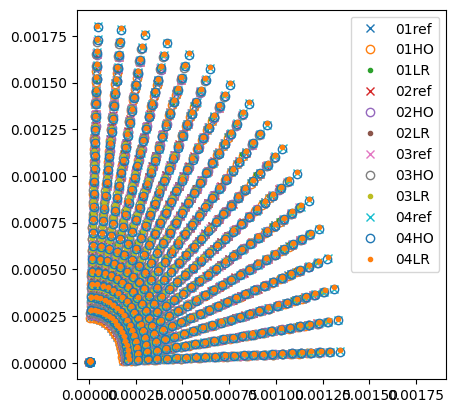

In [10]:

to_track = 'b4'
CONTOUR  = False
OUTFOLDER = './Tracking'
# for line_ID in ['base',
#                 'emitt_01',
#                 'emitt_02',
#                 'emitt_03',
#                 'emitt_04',
#                 'xing_01',twiss
    # #====================================
    # tracker,line,twiss,survey = import_from_lines(line_ID,to_track)
    # twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
    # twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..'])
    # #====================================
    
    # # Importing IP Objects
    # #====================================
    # IP1,IP5 = import_IP_config(line_ID,twiss,survey)
    # #====================================
    
#                 'xing_02',
#                 'xing_03',
#                 'xing_04']:

plt.figure()
for line_ID in ['base']:
    # # Importing and Filtering twiss
    # #====================================
    # tracker,line,twiss,survey = import_from_lines(line_ID,to_track)
    # twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
    # twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..'])
    # #====================================
    
    # # Importing IP Objects
    # #====================================
    # IP1,IP5 = import_IP_config(line_ID,twiss,survey)
    # #====================================
    
    

    for weak,numID in zip([1.9e-6,2.1e-6,2.3e-6,2.5e-6],['01','02','03','04']):

        IP1.b2.emittx_n = weak
        IP1.b2.emitty_n = weak
        line_ID = f'base_weak_{numID}'

        # REFERENCE
        #==========================
        tracker.vars[f'ip1_bbho_ON'] = 0
        tracker.vars[f'ip5_bbho_ON'] = 0

        tracker.vars[f'ip1_bblr_ON'] = 0
        tracker.vars[f'ip5_bblr_ON'] = 0

        tracker.vars['all_oct_ON']   = 0
        tracker.vars['all_sext_ON']  = 1
        #==========================

        particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
        particles.zeta  *= 0
        particles.delta *= 0
        
        


        
        plt.plot(particles.x,particles.y,'x',label = numID + 'ref')

        plt.axis('square')
        # plt.xlim([0,1.5])
        # plt.ylim([0,1.5])

        # Choosing knobs
        #==========================
        tracker.vars[f'ip1_bbho_ON'] = 1/10
        tracker.vars[f'ip5_bbho_ON'] = 1/10

        tracker.vars[f'ip1_bblr_ON'] = 0
        tracker.vars[f'ip5_bblr_ON'] = 0

        tracker.vars['all_oct_ON']   = 0
        tracker.vars['all_sext_ON']  = 1
        #==========================

        _cp_emittx_n = float(IP1.b2.emittx_n)
        _cp_emitty_n = float(IP1.b2.emitty_n)
        particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
        particles.zeta  *= 0
        particles.delta *= 0
        
        plt.plot(particles.x,particles.y,'o',mfc='none',label = numID + 'HO')

        # Choosing knobs
        #==========================
        tracker.vars[f'ip1_bbho_ON'] = 0
        tracker.vars[f'ip5_bbho_ON'] = 0

        tracker.vars[f'ip1_bblr_ON'] = 1/10
        tracker.vars[f'ip5_bblr_ON'] = 1/10

        tracker.vars['all_oct_ON']   = 0
        tracker.vars['all_sext_ON']  = 1
        #==========================


        particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
        particles.zeta *= 0
        particles.delta *= 0
        
        plt.plot(particles.x,particles.y,'.',label = numID + 'LR')




        # Choosing knobs
        #==========================
        tracker.vars[f'ip1_bbho_ON'] = 0
        tracker.vars[f'ip5_bbho_ON'] = 0

        tracker.vars[f'ip1_bblr_ON'] = 0
        tracker.vars[f'ip5_bblr_ON'] = 0

        tracker.vars['all_oct_ON']   = 1
        tracker.vars['all_sext_ON']  = 1

        I_oct = 430
        tracker.vars['I_oct'] = I_oct/10
        #==========================


        particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
        particles.zeta  *= 0
        particles.delta *= 0
        

        # Choosing knobs
        #==========================
        tracker.vars[f'ip1_bbho_ON'] = 0
        tracker.vars[f'ip5_bbho_ON'] = 0

        tracker.vars[f'ip1_bblr_ON'] = 0
        tracker.vars[f'ip5_bblr_ON'] = 0

        tracker.vars['I_oct'] = 0
        tracker.vars['all_oct_ON']   = 0
        tracker.vars['all_sext_ON']  = 1
        
    
        p0 = xp.Particles(mass0=tracker.line.particle_ref.mass0, q0 = tracker.line.particle_ref.q0 , p0c=tracker.line.particle_ref.p0c)
        particle_on_tracker_co = tracker.find_closed_orbit(particle_co_guess=p0)

        tracker.vars['enable_qff'] = 1

        _beam_el = {'b1':'b1','b4':'b2'}[to_track]
        tracker.vars[f"bbcw_rw_ip5.{_beam_el}"] = (18.85/2+3)*1e-3
        tracker.vars[f"bbcw_i_ip5.{_beam_el}"]  = 350/10

        # fixed to 12.4 instead of 12.3 to get 8.5 sig collimator at emitt=3.5e-6
        tracker.vars[f"bbcw_rw_ip1.{_beam_el}"] = (12.40/2+3)*1e-3
        tracker.vars[f"bbcw_i_ip1.{_beam_el}"]  = 350/10
        #==========================
        
        xf.configure_orbit_dependent_parameters_for_bb(tracker,particle_on_co=particle_on_tracker_co)

        particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
        particles.zeta  *= 0
        particles.delta *= 0
        
plt.legend()


In [9]:
%matplotlib inline

---
# PLOT normalized distance
---

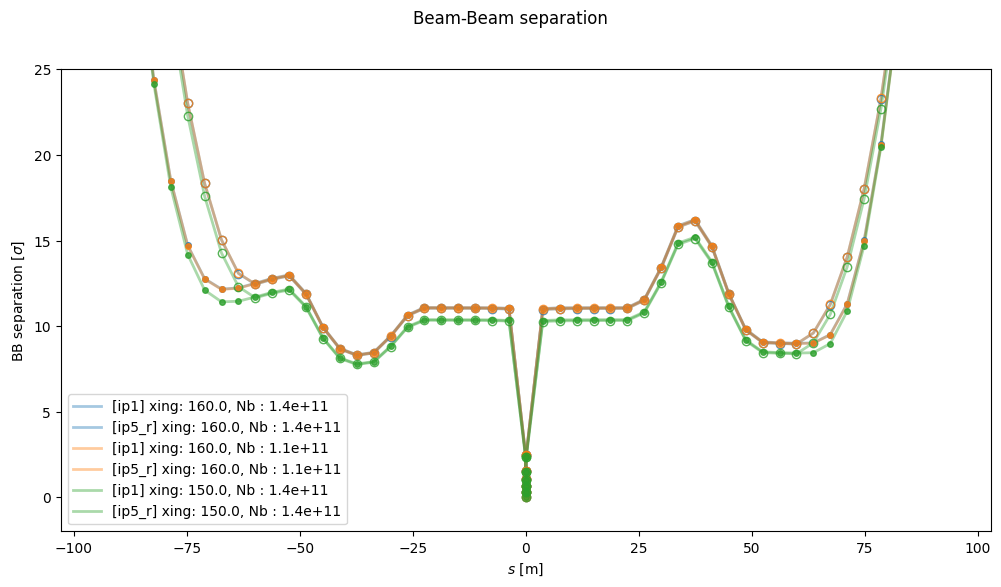

In [39]:
fig = plt.figure(figsize=(12,6))
fig.suptitle(f'Beam-Beam separation')


line_ID    = 'ID05_t0'
to_track   = 'b2'



for line_ID,color in zip(['ID05_t0','ID05_t0_test_intensity','ID05_t1'],['C0','C1','C2']):

    # Importing and Filtering twiss
    #====================================
    tracker,line,twiss,survey = import_from_lines(line_ID,to_track)
    twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
    twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..','bbcw'])
    #====================================

    # Importing IP Objects
    #====================================
    IP1,IP5 = import_IP_config(line_ID,twiss,survey)
    #====================================

    xing  = tracker.vars['on_x5']._value
    npart = tracker.element_refs[IP1.b2.lr.index[0]].other_beam_num_particles._value


    for _IP in [IP1,IP5]:

        # Plotting   

        dx_n_tot = np.sqrt(_IP.bb['dx_n']**2 + _IP.bb['dy_n']**2)
        if _IP.name == 'ip1':
            plt.plot(_IP.bb['s'],dx_n_tot,'-',color=color,alpha=0.4,lw=2,zorder=-10,label = f'[{_IP.name}] xing: {xing}, Nb : {npart:.1e}')
            plt.plot(_IP.bb['s'],dx_n_tot,ls='' ,color=color,alpha=0.8,marker='.',ms=8)
        else:
            plt.plot(-_IP.bb['s'],dx_n_tot,'-',color=color,alpha=0.4,lw=2,zorder=-9,label = f'[{_IP.name}_r] xing: {xing}, Nb : {npart:.1e}')
            plt.plot(-_IP.bb['s'],dx_n_tot,ls='' ,color=color,alpha=0.8,marker='.',mfc='none',ms=12)
        plt.legend()


        plt.xlabel(r'$s$ [m]')
        plt.ylabel(r'BB separation [$\sigma$]')

        plt.ylim([-2,25])

plt.show()


In [24]:
B2Wires 

['bbcwe_wire.4r5.d.b2',
 'bbcwi_wire.4r5.d.b2',
 'bbcwe_wire.4r5.u.b2',
 'bbcwi_wire.4r5.u.b2']

In [3]:
#====================================
line_ID = 'ID05_t0'
to_track = 'b4'
tracker,line,twiss,survey = import_from_lines(line_ID,to_track)
twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..'])
#====================================

# Importing IP Objects
#====================================
IP1,IP5 = import_IP_config(line_ID,twiss,survey)
#====================================

ip1 0.0010836826501517155 0.0007292115621566129
ip1 0.0010836826501517155 0.0007292115621566129
ip5 0.0011087177933622912 0.0007013809975054669
ip5 0.0011087177933622912 0.0007013809975054669
8.502333646032378
8.500810626857355


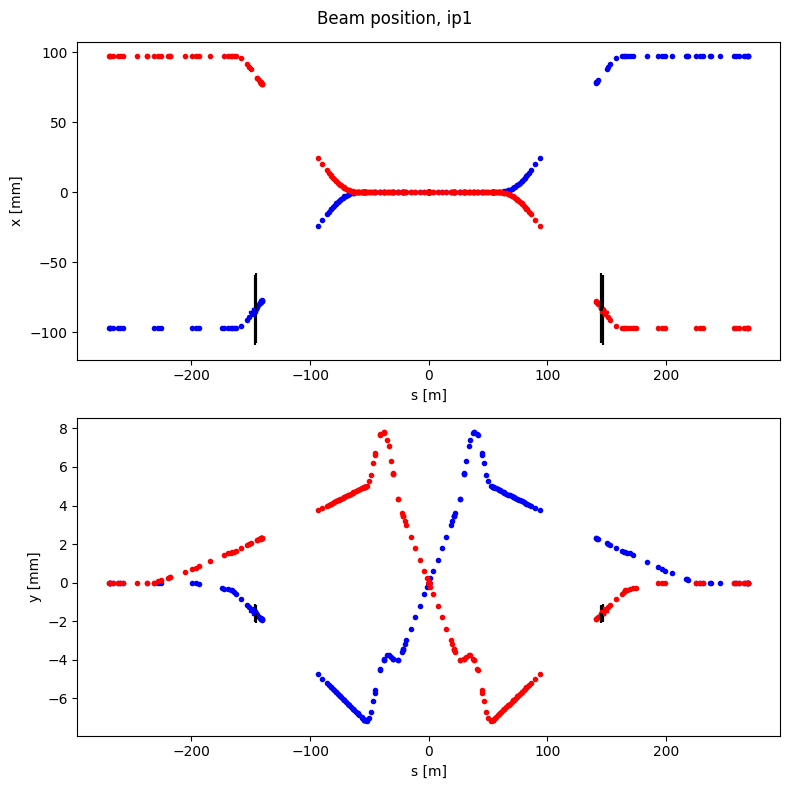

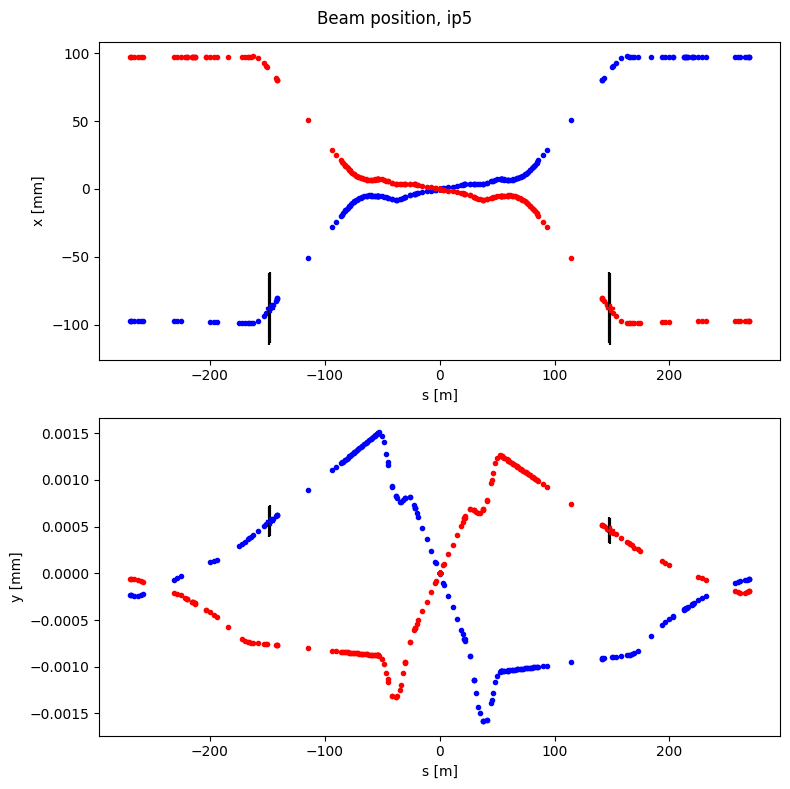

In [22]:

for _IP in [IP1,IP5]:

  
    # Plotting
    
    fig, axes = plt.subplots(2, 1,figsize=(8,8))
    fig.suptitle(f'Beam position, {_IP.name}')
    for plane,ax in zip(['x','y'],axes.flatten()):
        center = _IP.b1.twiss.loc[_IP.name,f'{plane}_lab']
        ax.plot(_IP.b1.twiss['s_lab'],(_IP.b1.twiss[f'{plane}_lab']-center)/1e-3,'.b')
        ax.plot(_IP.b2.twiss['s_lab'],(_IP.b2.twiss[f'{plane}_lab']-center)/1e-3,'.r')
        
        B1Wires = [name for name in _IP.b1.twiss.index if 'bbcw' in name] 
        B2Wires = [name for name in _IP.b2.twiss.index if 'bbcw' in name] 
        # for wire in B1Wires:
        #     ax.axvline(_IP.b1.twiss.loc[wire,'s_lab'])
        _y = (_IP.b1.twiss.loc[B1Wires,f'{plane}_lab']-center)/1e-3
        ax.vlines(_IP.b1.twiss.loc[B1Wires,'s_lab'],0.7*_y,1.3*_y,color='k')

        _y = (_IP.b2.twiss.loc[B2Wires,f'{plane}_lab']-center)/1e-3
        ax.vlines(_IP.b2.twiss.loc[B2Wires,'s_lab'],0.7*_y,1.3*_y,color='k')
        print(_IP.name,np.sqrt(3.5e-6/_IP.b2.gamma_r*_IP.b2.twiss.loc[B2Wires,'betx'].mean()),np.sqrt(3.5e-6/_IP.b2.gamma_r*_IP.b2.twiss.loc[B2Wires,'bety'].mean()))

        TCP = [name for name in _IP.b1.twiss.index if 'tctph' in name]
        ax.plot(_IP.b1.twiss.loc[TCP,'s_lab'],(_IP.b1.twiss.loc[TCP,f'{plane}_lab']-center)/1e-3,'P',color='b') 

        TCP = [name for name in _IP.b2.twiss.index if 'tctph' in name]
        ax.plot(_IP.b2.twiss.loc[TCP,'s_lab'],(_IP.b2.twiss.loc[TCP,f'{plane}_lab']-center)/1e-3,'P',color='r') 
        # print(_IP.name,np.sqrt(3.5e-6/_IP.b2.gamma_r*_IP.b2.twiss.loc[TCP,'betx'].mean()),np.sqrt(3.5e-6/_IP.b2.gamma_r*_IP.b2.twiss.loc[TCP,'bety'].mean()))


        ax.set(xlabel='s [m]', ylabel=f'{plane} [mm]')
        
    plt.tight_layout()


d_IP1 = (12.40/2)*1e-3
d_IP5 = (18.85/2)*1e-3
print(d_IP1/0.0007292115621566129)
print(d_IP5/0.0011087177933622912)

In [10]:
d_IP1

0.00915

In [11]:
d_IP5

0.012425

In [6]:
IP1.b2.gamma_r

7248.364799877625

In [4]:
_beam = 'b1'
tcp_iloc = np.arange(len(twiss[_beam]))[twiss[_beam].index.str.contains('tctpv.4l1') | twiss[_beam].index.str.contains('tctph.4l5')]
for i in tcp_iloc:
    display(twiss[_beam].iloc[i-5:i+5])

,s,x,px,y,py,zeta,delta,ptau,betx,bety,...,gamy,dx,dpx,dy,dzeta,dpy,mux,muy,muzeta,W_matrix
name,,,,,,,,,,,,,,,,,,,,,
mbrc.4l5.b1_dex,6511.393433,-0.001936,-0.000031,5.089429e-07,1.001128e-08,-0.000003,4.518672e-07,4.518672e-07,2574.838046,808.669361,...,0.297059,-0.920738,-0.002577,0.848163,-2.345698,0.016634,14.758939,14.026892,-0.000472,"[[50.742862016329894, 0.0, -1.946754491781443,..."
bpmwb.4l5.b1,6513.473933,-0.002000,-0.000031,5.297713e-07,1.001125e-08,-0.000003,4.518672e-07,4.518672e-07,2595.561713,874.313460,...,0.297057,-0.926035,-0.002577,0.882770,-2.345698,0.016634,14.759067,14.027284,-0.000472,"[[50.94665556279279, -2.220446049250313e-15, -..."
bbcwi_wire.4l5.u.b1,6516.028433,-0.002078,-0.000031,5.553450e-07,1.001125e-08,-0.000003,4.518672e-07,4.518672e-07,2621.124997,958.430421,...,0.297057,-0.932539,-0.002577,0.925262,-2.345698,0.016634,14.759222,14.027726,-0.000472,"[[51.196923708469754, 3.552713678800501e-15, -..."
bbcwe_wire.4l5.u.b1,6516.028433,-0.002078,-0.000031,5.553450e-07,1.001125e-08,-0.000003,4.518672e-07,4.518672e-07,2621.124997,958.430421,...,0.297057,-0.932539,-0.002577,0.925262,-2.345698,0.016634,14.759222,14.027726,-0.000472,"[[51.196923708469754, 3.552713678800501e-15, -..."
bptuh.a4l5.b1,6516.078433,-0.002079,-0.000031,5.558456e-07,1.001125e-08,-0.000003,4.518672e-07,4.518672e-07,2621.626655,960.115552,...,0.297057,-0.932667,-0.002577,0.926093,-2.345698,0.016634,14.759225,14.027735,-0.000472,"[[51.20182276584836, 4.440892098500626e-15, -1..."
tctph.4l5.b1,6516.623433,-0.002096,-0.000031,5.613017e-07,1.001125e-08,-0.000003,4.518672e-07,4.518672e-07,2627.097955,978.579806,...,0.297057,-0.934054,-0.002577,0.935159,-2.345698,0.016634,14.759258,14.027824,-0.000472,"[[51.25522368768046, 2.220446049250313e-15, -1..."
bptdh.a4l5.b1,6517.168433,-0.002113,-0.000031,5.667578e-07,1.001125e-08,-0.000003,4.518672e-07,4.518672e-07,2632.575184,997.220527,...,0.297057,-0.935442,-0.002577,0.944225,-2.345698,0.016634,14.759291,14.027911,-0.000472,"[[51.30862679649754, -3.9968028886505635e-15, ..."
bbcwi_wire.4l5.d.b1,6517.218433,-0.002114,-0.000031,5.672584e-07,1.001125e-08,-0.000003,4.518672e-07,4.518672e-07,2633.077979,998.939522,...,0.297057,-0.935569,-0.002577,0.945056,-2.345698,0.016634,14.759294,14.027919,-0.000472,"[[51.31352627356206, 2.220446049250313e-15, -1..."
bbcwe_wire.4l5.d.b1,6517.218433,-0.002114,-0.000031,5.672584e-07,1.001125e-08,-0.000003,4.518672e-07,4.518672e-07,2633.077979,998.939522,...,0.297057,-0.935569,-0.002577,0.945056,-2.345698,0.016634,14.759294,14.027919,-0.000472,"[[51.31352627356206, 2.220446049250313e-15, -1..."


,s,x,px,y,py,zeta,delta,ptau,betx,bety,...,gamy,dx,dpx,dy,dzeta,dpy,mux,muy,muzeta,W_matrix
name,,,,,,,,,,,,,,,,,,,,,
tctph.4l1.b1,19846.2174,-2.157982e-07,-6.235929e-10,-0.001467,-0.00006,0.000004,4.518672e-07,4.518672e-07,2714.116340,1053.040599,...,0.323345,-0.307655,-0.001258,-0.584015,-6.962737,-0.009429,46.123020,44.741759,-0.001401,"[[52.09718169062724, 3.552713678800501e-15, 3...."
bptdh.a4l1.b1,19846.8124,-2.161693e-07,-6.235929e-10,-0.001502,-0.00006,0.000004,4.518672e-07,4.518672e-07,2720.250103,1075.081563,...,0.323345,-0.308404,-0.001258,-0.589589,-6.962737,-0.009429,46.123055,44.741847,-0.001401,"[[52.1560169361386, 0.0, 3.473668767821655, 0...."
bbcwt_wire.a4l1.u.b1,19847.6224,-2.166744e-07,-6.235929e-10,-0.001551,-0.00006,0.000004,4.518672e-07,4.518672e-07,2728.611810,1105.454890,...,0.323345,-0.309423,-0.001258,-0.597177,-6.962738,-0.009429,46.123102,44.741965,-0.001401,"[[52.2361159511329, 0.0, 3.479120957566174, 0...."
bbcwb_wire.a4l1.u.b1,19847.6224,-2.166744e-07,-6.235929e-10,-0.001551,-0.00006,0.000004,4.518672e-07,4.518672e-07,2728.611810,1105.454890,...,0.323345,-0.309423,-0.001258,-0.597177,-6.962738,-0.009429,46.123102,44.741965,-0.001401,"[[52.2361159511329, 0.0, 3.479120957566174, 0...."
bptuv.a4l1.b1,19847.6724,-2.167055e-07,-6.235929e-10,-0.001554,-0.00006,0.000004,4.518672e-07,4.518672e-07,2729.128401,1107.343691,...,0.323345,-0.309486,-0.001258,-0.597646,-6.962738,-0.009429,46.123105,44.741972,-0.001401,"[[52.24106048454767, -3.552713678800501e-15, 3..."
tctpv.4l1.b1,19848.2174,-2.170454e-07,-6.235929e-10,-0.001587,-0.00006,0.000004,4.518672e-07,4.518672e-07,2734.762530,1128.036470,...,0.323345,-0.310171,-0.001258,-0.602751,-6.962738,-0.009429,46.123136,44.742050,-0.001401,"[[52.29495702525023, -3.552713678800501e-15, 3..."
bptdv.a4l1.b1,19848.7624,-2.173853e-07,-6.235929e-10,-0.001620,-0.00006,0.000004,4.518672e-07,4.518672e-07,2740.402685,1148.921332,...,0.323345,-0.310857,-0.001258,-0.607857,-6.962738,-0.009429,46.123168,44.742125,-0.001401,"[[52.34885562514495, 0.0, 3.4867913923779974, ..."
bbcwt_wire.a4l1.d.b1,19848.8124,-2.174164e-07,-6.235929e-10,-0.001623,-0.00006,0.000004,4.518672e-07,4.518672e-07,2740.920432,1150.846994,...,0.323345,-0.310919,-0.001258,-0.608326,-6.962738,-0.009429,46.123171,44.742132,-0.001401,"[[52.35380055372586, -3.552713678800501e-15, 3..."
bbcwb_wire.a4l1.d.b1,19848.8124,-2.174164e-07,-6.235929e-10,-0.001623,-0.00006,0.000004,4.518672e-07,4.518672e-07,2740.920432,1150.846994,...,0.323345,-0.310919,-0.001258,-0.608326,-6.962738,-0.009429,46.123171,44.742132,-0.001401,"[[52.35380055372586, -3.552713678800501e-15, 3..."


In [43]:
line['b4'].element_refs['bbcwe_wire.4r5.u.b2'].knobs()

╭─────── <xtrack.beam_elements.elements.Wire object at 0x7f3be2457820> ───────╮
│ ╭─────────────────────────────────────────────────────────────────────────╮ │
│ │ <BBStudies.Tracking.XsuitePlus.RenderingKnobs object at 0x7f3bb55c3a30> │ │
│ ╰─────────────────────────────────────────────────────────────────────────╯ │
│                                                                             │
│ 'vars['bbcwe_current.4r5.b2']' = 0                                          │
│   'vars['bbcwe_xma.4r5.u.b2']' = 1.0020774718076102                         │
│   'vars['bbcwe_yma.4r5.u.b2']' = 1.2267802037448714e-07                     │
│ ------------------------------ = '------------------------------'           │
│                        current = "(vars['bbcwe_current.4r5.b2']/2.0)"       │
│                          L_int = None                                       │
│                          L_phy = None                                       │
│               post_subtract_px = None                                       │
│               post_subtract_py = None                                       │
│                            xma = "vars['bbcwe_xma.4r5.u.b2']"               │
│                            yma = "vars['bbcwe_yma.4r5.u.b2']"               │
╰─────────────────────────────────────────────────────────────────────────────╯

In [6]:
_beam = 'b4'
tcp_iloc = np.arange(len(twiss[_beam]))[twiss[_beam].index.str.contains('tctpv.4r1') | twiss[_beam].index.str.contains('tctph.4r5')]
for i in tcp_iloc:
    display(twiss[_beam].iloc[i-5:i+5])

,s,x,px,y,py,zeta,delta,ptau,betx,bety,...,gamy,dx,dpx,dy,dzeta,dpy,mux,muy,muzeta,W_matrix
name,,,,,,,,,,,,,,,,,,,,,
drift_7827,6517.3708,7.319931e-07,2.162619e-09,-0.001502,-0.00006,-0.000002,4.401148e-07,4.401148e-07,2419.437181,1049.399912,...,0.316038,1.244812,0.003971,-0.571642,-2.340100,-0.009127,15.605123,15.188761,-0.000471,"[[49.18777471282033, 7.105427357601002e-15, -3..."
bptuv.a4r1.b2,6518.1808,7.337448e-07,2.162619e-09,-0.001551,-0.00006,-0.000002,4.401148e-07,4.401148e-07,2426.714707,1079.065330,...,0.316038,1.248029,0.003971,-0.578986,-2.340100,-0.009127,15.605176,15.188882,-0.000471,"[[49.26169614417282, 0.0, -3.024845689389089, ..."
bbcwt_wire.a4r1.u.b2,6518.1808,7.337448e-07,2.162619e-09,-0.001551,-0.00006,-0.000002,4.401148e-07,4.401148e-07,2426.714707,1079.065330,...,0.316038,1.248029,0.003971,-0.578986,-2.340100,-0.009127,15.605176,15.188882,-0.000471,"[[49.26169614417282, 0.0, -3.024845689389089, ..."
bbcwb_wire.a4r1.u.b2,6518.1808,7.337448e-07,2.162619e-09,-0.001551,-0.00006,-0.000002,4.401148e-07,4.401148e-07,2426.714707,1079.065330,...,0.316038,1.248029,0.003971,-0.578986,-2.340100,-0.009127,15.605176,15.188882,-0.000471,"[[49.26169614417282, 0.0, -3.024845689389089, ..."
drift_7828,6518.1808,7.337448e-07,2.162619e-09,-0.001551,-0.00006,-0.000002,4.401148e-07,4.401148e-07,2426.714707,1079.065330,...,0.316038,1.248029,0.003971,-0.578986,-2.340100,-0.009127,15.605176,15.188882,-0.000471,"[[49.26169614417282, 0.0, -3.024845689389089, ..."
tctpv.4r1.b2,6518.7758,7.350315e-07,2.162619e-09,-0.001587,-0.00006,-0.000002,4.401148e-07,4.401148e-07,2432.067849,1101.120793,...,0.316038,1.250392,0.003971,-0.584381,-2.340101,-0.009127,15.605215,15.188969,-0.000471,"[[49.31599992733608, 3.552713678800501e-15, -3..."
drift_7829,6518.7758,7.350315e-07,2.162619e-09,-0.001587,-0.00006,-0.000002,4.401148e-07,4.401148e-07,2432.067849,1101.120793,...,0.316038,1.250392,0.003971,-0.584381,-2.340101,-0.009127,15.605215,15.188969,-0.000471,"[[49.31599992733608, 3.552713678800501e-15, -3..."
bbcwt_wire.a4r1.d.b2,6519.3708,7.363183e-07,2.162619e-09,-0.001623,-0.00006,-0.000002,4.401148e-07,4.401148e-07,2437.427178,1123.400028,...,0.316038,1.252755,0.003971,-0.589776,-2.340101,-0.009127,15.605253,15.189053,-0.000471,"[[49.37030664072791, 0.0, -3.0316732666082036,..."
bbcwb_wire.a4r1.d.b2,6519.3708,7.363183e-07,2.162619e-09,-0.001623,-0.00006,-0.000002,4.401148e-07,4.401148e-07,2437.427178,1123.400028,...,0.316038,1.252755,0.003971,-0.589776,-2.340101,-0.009127,15.605253,15.189053,-0.000471,"[[49.37030664072791, 0.0, -3.0316732666082036,..."


,s,x,px,y,py,zeta,delta,ptau,betx,bety,...,gamy,dx,dpx,dy,dzeta,dpy,mux,muy,muzeta,W_matrix
name,,,,,,,,,,,,,,,,,,,,,
drift_23136,19842.839533,0.001997,0.000031,4.373590e-07,8.464407e-09,-0.000008,4.401148e-07,4.401148e-07,2514.482869,907.571108,...,0.30924,0.894334,0.002516,0.757243,-6.970785,0.014582,46.847182,45.740966,-0.001403,"[[50.14461954310156, -3.552713678800501e-15, 0..."
bbcwi_wire.4r5.u.b2,19845.470033,0.002078,0.000031,4.596246e-07,8.464407e-09,-0.000008,4.401148e-07,4.401148e-07,2539.956085,997.691476,...,0.30924,0.900873,0.002516,0.795600,-6.970785,0.014582,46.847347,45.741404,-0.001403,"[[50.39797698856623, 0.0, 0.8108542041031888, ..."
bbcwe_wire.4r5.u.b2,19845.470033,0.002078,0.000031,4.596246e-07,8.464407e-09,-0.000008,4.401148e-07,4.401148e-07,2539.956085,997.691476,...,0.30924,0.900873,0.002516,0.795600,-6.970785,0.014582,46.847347,45.741404,-0.001403,"[[50.39797698856623, 0.0, 0.8108542041031888, ..."
bptuh.a4r5.b2,19845.470033,0.002078,0.000031,4.596246e-07,8.464407e-09,-0.000008,4.401148e-07,4.401148e-07,2539.956085,997.691476,...,0.30924,0.900873,0.002516,0.795600,-6.970785,0.014582,46.847347,45.741404,-0.001403,"[[50.39797698856623, 0.0, 0.8108542041031888, ..."
drift_23137,19845.470033,0.002078,0.000031,4.596246e-07,8.464407e-09,-0.000008,4.401148e-07,4.401148e-07,2539.956085,997.691476,...,0.30924,0.900873,0.002516,0.795600,-6.970785,0.014582,46.847347,45.741404,-0.001403,"[[50.39797698856623, 0.0, 0.8108542041031888, ..."
tctph.4r5.b2,19846.065033,0.002096,0.000031,4.646609e-07,8.464407e-09,-0.000008,4.401148e-07,4.401148e-07,2545.736498,1018.669533,...,0.30924,0.902352,0.002516,0.804276,-6.970785,0.014582,46.847384,45.741498,-0.001403,"[[50.45529207430755, -3.552713678800501e-15, 0..."
drift_23138,19846.065033,0.002096,0.000031,4.646609e-07,8.464407e-09,-0.000008,4.401148e-07,4.401148e-07,2545.736498,1018.669533,...,0.30924,0.902352,0.002516,0.804276,-6.970785,0.014582,46.847384,45.741498,-0.001403,"[[50.45529207430755, -3.552713678800501e-15, 0..."
bbcwi_wire.4r5.d.b2,19846.660033,0.002114,0.000031,4.696973e-07,8.464407e-09,-0.000008,4.401148e-07,4.401148e-07,2551.523759,1039.866547,...,0.30924,0.903831,0.002516,0.812952,-6.970785,0.014582,46.847421,45.741589,-0.001403,"[[50.512609896355464, 3.552713678800501e-15, 0..."
bbcwe_wire.4r5.d.b2,19846.660033,0.002114,0.000031,4.696973e-07,8.464407e-09,-0.000008,4.401148e-07,4.401148e-07,2551.523759,1039.866547,...,0.30924,0.903831,0.002516,0.812952,-6.970785,0.014582,46.847421,45.741589,-0.001403,"[[50.512609896355464, 3.552713678800501e-15, 0..."


In [45]:
_beam = 'b4'
tcp_iloc = np.arange(len(twiss[_beam]))[twiss[_beam].index.str.contains('tctpv.4r1') | twiss[_beam].index.str.contains('tctph.4r5')]
for i in tcp_iloc:
    display(twiss[_beam].iloc[i-10:i+10])

,s,x,px,y,py,zeta,delta,ptau,betx,bety,...,gamy,dx,dpx,dy,dzeta,dpy,mux,muy,muzeta,W_matrix
name,,,,,,,,,,,,,,,,,,,,,
bptuh.a4r1.b2,6516.1808,7.301918e-07,2.163594e-09,-0.001431,-0.00006,-0.000002,4.401152e-07,4.401152e-07,2408.765641,1006.569310,...,0.316038,1.240086,0.003971,-0.560853,-2.339996,-0.009127,15.605045,15.188578,-0.000471,"[[49.07917726923391, -3.552713678800501e-15, -..."
drift_7825,6516.1808,7.301918e-07,2.163594e-09,-0.001431,-0.00006,-0.000002,4.401152e-07,4.401152e-07,2408.765641,1006.569310,...,0.316038,1.240086,0.003971,-0.560853,-2.339996,-0.009127,15.605045,15.188578,-0.000471,"[[49.07917726923391, -3.552713678800501e-15, -..."
tctph.4r1.b2,6516.7758,7.314791e-07,2.163594e-09,-0.001467,-0.00006,-0.000002,4.401152e-07,4.401152e-07,2414.097985,1027.872598,...,0.316038,1.242449,0.003971,-0.566248,-2.339997,-0.009127,15.605084,15.188671,-0.000471,"[[49.13347112423083, -3.552713678800501e-15, -..."
drift_7826,6516.7758,7.314791e-07,2.163594e-09,-0.001467,-0.00006,-0.000002,4.401152e-07,4.401152e-07,2414.097985,1027.872598,...,0.316038,1.242449,0.003971,-0.566248,-2.339997,-0.009127,15.605084,15.188671,-0.000471,"[[49.13347112423083, -3.552713678800501e-15, -..."
bptdh.a4r1.b2,6517.3708,7.327665e-07,2.163594e-09,-0.001502,-0.00006,-0.000002,4.401152e-07,4.401152e-07,2419.436515,1049.399657,...,0.316038,1.244812,0.003971,-0.571642,-2.339997,-0.009127,15.605123,15.188761,-0.000471,"[[49.18776794223478, -7.105427357601002e-15, -..."
drift_7827,6517.3708,7.327665e-07,2.163594e-09,-0.001502,-0.00006,-0.000002,4.401152e-07,4.401152e-07,2419.436515,1049.399657,...,0.316038,1.244812,0.003971,-0.571642,-2.339997,-0.009127,15.605123,15.188761,-0.000471,"[[49.18776794223478, -7.105427357601002e-15, -..."
bptuv.a4r1.b2,6518.1808,7.345190e-07,2.163594e-09,-0.001551,-0.00006,-0.000002,4.401152e-07,4.401152e-07,2426.714039,1079.065067,...,0.316038,1.248029,0.003971,-0.578986,-2.339997,-0.009127,15.605176,15.188882,-0.000471,"[[49.26168936364664, 7.105427357601002e-15, -3..."
bbcwt_wire.a4r1.u.b2,6518.1808,7.345190e-07,2.163594e-09,-0.001551,-0.00006,-0.000002,4.401152e-07,4.401152e-07,2426.714039,1079.065067,...,0.316038,1.248029,0.003971,-0.578986,-2.339997,-0.009127,15.605176,15.188882,-0.000471,"[[49.26168936364664, 7.105427357601002e-15, -3..."
bbcwb_wire.a4r1.u.b2,6518.1808,7.345190e-07,2.163594e-09,-0.001551,-0.00006,-0.000002,4.401152e-07,4.401152e-07,2426.714039,1079.065067,...,0.316038,1.248029,0.003971,-0.578986,-2.339997,-0.009127,15.605176,15.188882,-0.000471,"[[49.26168936364664, 7.105427357601002e-15, -3..."


,s,x,px,y,py,zeta,delta,ptau,betx,bety,...,gamy,dx,dpx,dy,dzeta,dpy,mux,muy,muzeta,W_matrix
name,,,,,,,,,,,,,,,,,,,,,
mbrc.4r5.b2_dex,19840.835033,0.001936,0.000031,4.208906e-07,8.473235e-09,-0.000008,4.401152e-07,4.401152e-07,2495.161011,841.770210,...,0.309242,0.889351,0.002516,0.728014,-6.970681,0.014582,46.847055,45.740602,-0.001403,"[[49.95158667347502, 0.0, 0.794508104286638, 2..."
drift_23138,19840.835033,0.001936,0.000031,4.208906e-07,8.473206e-09,-0.000008,4.401152e-07,4.401152e-07,2495.161011,841.770210,...,0.309240,0.889351,0.002516,0.728014,-6.970681,0.014582,46.847055,45.740602,-0.001403,"[[49.95158667347502, 0.0, 0.794508104286638, 2..."
bpmwb.4r5.b2,19842.839533,0.001997,0.000031,4.378752e-07,8.473206e-09,-0.000008,4.401152e-07,4.401152e-07,2514.482331,907.570831,...,0.309240,0.894334,0.002516,0.757243,-6.970681,0.014582,46.847182,45.740966,-0.001403,"[[50.14461417255006, 0.0, 0.8018556056689972, ..."
drift_23139,19842.839533,0.001997,0.000031,4.378752e-07,8.473206e-09,-0.000008,4.401152e-07,4.401152e-07,2514.482331,907.570831,...,0.309240,0.894334,0.002516,0.757243,-6.970681,0.014582,46.847182,45.740966,-0.001403,"[[50.14461417255006, 0.0, 0.8018556056689972, ..."
bbcwi_wire.4r5.u.b2,19845.420033,0.002076,0.000031,4.597403e-07,8.473206e-09,-0.000008,4.401152e-07,4.401152e-07,2539.470103,995.938283,...,0.309240,0.900748,0.002516,0.794871,-6.970682,0.014582,46.847344,45.741396,-0.001403,"[[50.39315531881152, 0.0, 0.8107019999488809, ..."
drift_23140,19845.420033,0.002076,0.000031,4.597403e-07,8.473206e-09,-0.000008,4.401152e-07,4.401152e-07,2539.470103,995.938283,...,0.309240,0.900748,0.002516,0.794871,-6.970682,0.014582,46.847344,45.741396,-0.001403,"[[50.39315531881152, 0.0, 0.8107019999488809, ..."
bptuh.a4r5.b2,19845.470033,0.002078,0.000031,4.601639e-07,8.473206e-09,-0.000008,4.401152e-07,4.401152e-07,2539.955540,997.691171,...,0.309240,0.900873,0.002516,0.795600,-6.970682,0.014582,46.847347,45.741404,-0.001403,"[[50.397971587057, 0.0, 0.8108671587091572, 2...."
bbcwi_wire.4r5.d.b2,19845.470033,0.002078,0.000031,4.601639e-07,8.473206e-09,-0.000008,4.401152e-07,4.401152e-07,2539.955540,997.691171,...,0.309240,0.900873,0.002516,0.795600,-6.970682,0.014582,46.847347,45.741404,-0.001403,"[[50.397971587057, 0.0, 0.8108671587091572, 2...."
bbcwe_wire.4r5.u.b2,19845.470033,0.002078,0.000031,4.601639e-07,8.473206e-09,-0.000008,4.401152e-07,4.401152e-07,2539.955540,997.691171,...,0.309240,0.900873,0.002516,0.795600,-6.970682,0.014582,46.847347,45.741404,-0.001403,"[[50.397971587057, 0.0, 0.8108671587091572, 2...."


In [27]:
for i in tcp_iloc:
    display(twiss['b4'].iloc[i-5:i+5])

,s,x,px,y,py,zeta,delta,ptau,betx,bety,...,gamy,dx,dpx,dy,dzeta,dpy,mux,muy,muzeta,W_matrix
name,,,,,,,,,,,,,,,,,,,,,
drift_3547,3210.758584,-5.107534e-07,0.000001,-1.051140e-07,-1.172930e-09,-0.000001,4.401152e-07,4.401152e-07,76.652648,109.968993,...,0.010379,0.361389,-0.001011,-0.167520,-1.174607,-0.001994,7.752721,6.868235,-0.000236,"[[8.755149820692893, -3.608224830031759e-16, 0..."
bpmwb.4r2.b2,3212.839084,1.836193e-06,0.000001,-1.075543e-07,-1.172930e-09,-0.000001,4.401152e-07,4.401152e-07,78.730261,108.409777,...,0.010379,0.359283,-0.001011,-0.171668,-1.174607,-0.001994,7.756968,6.871257,-0.000236,"[[8.873007437329406, 7.216449660063518e-16, 0...."
drift_3548,3212.839084,1.836193e-06,0.000001,-1.075543e-07,-1.172930e-09,-0.000001,4.401152e-07,4.401152e-07,78.730261,108.409777,...,0.010379,0.359283,-0.001011,-0.171668,-1.174607,-0.001994,7.756968,6.871257,-0.000236,"[[8.873007437329406, 7.216449660063518e-16, 0...."
bptuh.a4r2.b2,3213.308584,2.365821e-06,0.000001,-1.081050e-07,-1.172930e-09,-0.000001,4.401152e-07,4.401152e-07,79.218253,108.070339,...,0.010379,0.358808,-0.001011,-0.172604,-1.174607,-0.001994,7.757911,6.871944,-0.000236,"[[8.900463663536817, -5.551115123125783e-17, 0..."
drift_3549,3213.308584,2.365821e-06,0.000001,-1.081050e-07,-1.172930e-09,-0.000001,4.401152e-07,4.401152e-07,79.218253,108.070339,...,0.010379,0.358808,-0.001011,-0.172604,-1.174607,-0.001994,7.757911,6.871944,-0.000236,"[[8.900463663536817, -5.551115123125783e-17, 0..."
tctph.4r2.b2,3213.903584,3.037022e-06,0.000001,-1.088029e-07,-1.172930e-09,-0.000001,4.401152e-07,4.401152e-07,79.846817,107.646742,...,0.010379,0.358206,-0.001011,-0.173791,-1.174607,-0.001994,7.759097,6.872819,-0.000236,"[[8.935704612638691, -1.1102230246251565e-16, ..."
drift_3550,3213.903584,3.037022e-06,0.000001,-1.088029e-07,-1.172930e-09,-0.000001,4.401152e-07,4.401152e-07,79.846817,107.646742,...,0.010379,0.358206,-0.001011,-0.173791,-1.174607,-0.001994,7.759097,6.872819,-0.000236,"[[8.935704612638691, -1.1102230246251565e-16, ..."
bptdh.a4r2.b2,3214.498584,3.708223e-06,0.000001,-1.095008e-07,-1.172930e-09,-0.000001,4.401152e-07,4.401152e-07,80.486702,107.230493,...,0.010379,0.357604,-0.001011,-0.174977,-1.174607,-0.001994,7.760274,6.873697,-0.000236,"[[8.971438144593685, 0.0, 0.5460567030178961, ..."
drift_3551,3214.498584,3.708223e-06,0.000001,-1.095008e-07,-1.172930e-09,-0.000001,4.401152e-07,4.401152e-07,80.486702,107.230493,...,0.010379,0.357604,-0.001011,-0.174977,-1.174607,-0.001994,7.760274,6.873697,-0.000236,"[[8.971438144593685, 0.0, 0.5460567030178961, ..."


,s,x,px,y,py,zeta,delta,ptau,betx,bety,...,gamy,dx,dpx,dy,dzeta,dpy,mux,muy,muzeta,W_matrix
name,,,,,,,,,,,,,,,,,,,,,
drift_7823,6511.5458,7.201635e-07,2.163594e-09,-0.001152,-0.00006,-0.000002,4.401152e-07,4.401152e-07,2367.438960,848.279579,...,0.316038,1.221679,0.003971,-0.518829,-2.339994,-0.009127,15.604737,15.187782,-0.000471,"[[48.65633525195085, 1.0658141036401503e-14, -..."
bpmwb.4r1.b2,6513.5503,7.245005e-07,2.163594e-09,-0.001272,-0.00006,-0.000002,4.401152e-07,4.401152e-07,2385.265448,915.068775,...,0.316038,1.229640,0.003971,-0.537003,-2.339995,-0.009127,15.604871,15.188143,-0.000471,"[[48.839179439671554, -7.105427357601002e-15, ..."
drift_7824,6513.5503,7.245005e-07,2.163594e-09,-0.001272,-0.00006,-0.000002,4.401152e-07,4.401152e-07,2385.265448,915.068775,...,0.316038,1.229640,0.003971,-0.537003,-2.339995,-0.009127,15.604871,15.188143,-0.000471,"[[48.839179439671554, -7.105427357601002e-15, ..."
bptuh.a4r1.b2,6516.1808,7.301918e-07,2.163594e-09,-0.001431,-0.00006,-0.000002,4.401152e-07,4.401152e-07,2408.765641,1006.569310,...,0.316038,1.240086,0.003971,-0.560853,-2.339996,-0.009127,15.605045,15.188578,-0.000471,"[[49.07917726923391, -3.552713678800501e-15, -..."
drift_7825,6516.1808,7.301918e-07,2.163594e-09,-0.001431,-0.00006,-0.000002,4.401152e-07,4.401152e-07,2408.765641,1006.569310,...,0.316038,1.240086,0.003971,-0.560853,-2.339996,-0.009127,15.605045,15.188578,-0.000471,"[[49.07917726923391, -3.552713678800501e-15, -..."
tctph.4r1.b2,6516.7758,7.314791e-07,2.163594e-09,-0.001467,-0.00006,-0.000002,4.401152e-07,4.401152e-07,2414.097985,1027.872598,...,0.316038,1.242449,0.003971,-0.566248,-2.339997,-0.009127,15.605084,15.188671,-0.000471,"[[49.13347112423083, -3.552713678800501e-15, -..."
drift_7826,6516.7758,7.314791e-07,2.163594e-09,-0.001467,-0.00006,-0.000002,4.401152e-07,4.401152e-07,2414.097985,1027.872598,...,0.316038,1.242449,0.003971,-0.566248,-2.339997,-0.009127,15.605084,15.188671,-0.000471,"[[49.13347112423083, -3.552713678800501e-15, -..."
bptdh.a4r1.b2,6517.3708,7.327665e-07,2.163594e-09,-0.001502,-0.00006,-0.000002,4.401152e-07,4.401152e-07,2419.436515,1049.399657,...,0.316038,1.244812,0.003971,-0.571642,-2.339997,-0.009127,15.605123,15.188761,-0.000471,"[[49.18776794223478, -7.105427357601002e-15, -..."
drift_7827,6517.3708,7.327665e-07,2.163594e-09,-0.001502,-0.00006,-0.000002,4.401152e-07,4.401152e-07,2419.436515,1049.399657,...,0.316038,1.244812,0.003971,-0.571642,-2.339997,-0.009127,15.605123,15.188761,-0.000471,"[[49.18776794223478, -7.105427357601002e-15, -..."


,s,x,px,y,py,zeta,delta,ptau,betx,bety,...,gamy,dx,dpx,dy,dzeta,dpy,mux,muy,muzeta,W_matrix
name,,,,,,,,,,,,,,,,,,,,,
drift_12196,9886.699384,2.897104e-07,1.604020e-09,0.000018,9.297480e-08,-0.000004,4.401152e-07,4.401152e-07,316.019653,442.677226,...,0.003294,0.514777,0.002401,-0.029434,-3.498194,-0.001538,23.819254,23.101115,-0.000704,"[[17.776941596763788, 0.0, 0.4306036187881183,..."
tanb.a4r8.b2,9888.891884,2.932273e-07,1.604020e-09,0.000018,9.297480e-08,-0.000004,4.401152e-07,4.401152e-07,333.153787,445.684322,...,0.003294,0.520042,0.002401,-0.032806,-3.498194,-0.001538,23.820326,23.101898,-0.000704,"[[18.25250083578053, 1.7763568394002505e-15, 0..."
drift_12197,9888.891884,2.932273e-07,1.604020e-09,0.000018,9.297480e-08,-0.000004,4.401152e-07,4.401152e-07,333.153787,445.684322,...,0.003294,0.520042,0.002401,-0.032806,-3.498194,-0.001538,23.820326,23.101898,-0.000704,"[[18.25250083578053, 1.7763568394002505e-15, 0..."
bptuh.a4r8.b2,9889.549384,2.942819e-07,1.604020e-09,0.000018,9.297480e-08,-0.000004,4.401152e-07,4.401152e-07,338.385966,446.592279,...,0.003294,0.521621,0.002401,-0.033817,-3.498194,-0.001538,23.820636,23.102131,-0.000704,"[[18.395270215889184, 1.7763568394002505e-15, ..."
drift_12198,9889.549384,2.942819e-07,1.604020e-09,0.000018,9.297480e-08,-0.000004,4.401152e-07,4.401152e-07,338.385966,446.592279,...,0.003294,0.521621,0.002401,-0.033817,-3.498194,-0.001538,23.820636,23.102131,-0.000704,"[[18.395270215889184, 1.7763568394002505e-15, ..."
tctph.4r8.b2,9890.144384,2.952363e-07,1.604020e-09,0.000018,9.297480e-08,-0.000004,4.401152e-07,4.401152e-07,343.158132,447.416384,...,0.003294,0.523050,0.002401,-0.034732,-3.498194,-0.001538,23.820913,23.102342,-0.000704,"[[18.524527835275705, 0.0, 0.452304362228352, ..."
drift_12199,9890.144384,2.952363e-07,1.604020e-09,0.000018,9.297480e-08,-0.000004,4.401152e-07,4.401152e-07,343.158132,447.416384,...,0.003294,0.523050,0.002401,-0.034732,-3.498194,-0.001538,23.820913,23.102342,-0.000704,"[[18.524527835275705, 0.0, 0.452304362228352, ..."
bptdh.a4r8.b2,9890.739384,2.961907e-07,1.604020e-09,0.000018,9.297480e-08,-0.000004,4.401152e-07,4.401152e-07,347.965775,448.242820,...,0.003294,0.524479,0.002401,-0.035647,-3.498194,-0.001538,23.821186,23.102553,-0.000704,"[[18.653840744332154, -8.881784197001252e-16, ..."
drift_12200,9890.739384,2.961907e-07,1.604020e-09,0.000018,9.297480e-08,-0.000004,4.401152e-07,4.401152e-07,347.965775,448.242820,...,0.003294,0.524479,0.002401,-0.035647,-3.498194,-0.001538,23.821186,23.102553,-0.000704,"[[18.653840744332154, -8.881784197001252e-16, ..."


,s,x,px,y,py,zeta,delta,ptau,betx,bety,...,gamy,dx,dpx,dy,dzeta,dpy,mux,muy,muzeta,W_matrix
name,,,,,,,,,,,,,,,,,,,,,
drift_23140,19845.420033,0.002076,0.000031,4.597403e-07,8.473206e-09,-0.000008,4.401152e-07,4.401152e-07,2539.470103,995.938283,...,0.30924,0.900748,0.002516,0.794871,-6.970682,0.014582,46.847344,45.741396,-0.001403,"[[50.39315531881152, 0.0, 0.8107019999488809, ..."
bptuh.a4r5.b2,19845.470033,0.002078,0.000031,4.601639e-07,8.473206e-09,-0.000008,4.401152e-07,4.401152e-07,2539.955540,997.691171,...,0.30924,0.900873,0.002516,0.795600,-6.970682,0.014582,46.847347,45.741404,-0.001403,"[[50.397971587057, 0.0, 0.8108671587091572, 2...."
bbcwi_wire.4r5.d.b2,19845.470033,0.002078,0.000031,4.601639e-07,8.473206e-09,-0.000008,4.401152e-07,4.401152e-07,2539.955540,997.691171,...,0.30924,0.900873,0.002516,0.795600,-6.970682,0.014582,46.847347,45.741404,-0.001403,"[[50.397971587057, 0.0, 0.8108671587091572, 2...."
bbcwe_wire.4r5.u.b2,19845.470033,0.002078,0.000031,4.601639e-07,8.473206e-09,-0.000008,4.401152e-07,4.401152e-07,2539.955540,997.691171,...,0.30924,0.900873,0.002516,0.795600,-6.970682,0.014582,46.847347,45.741404,-0.001403,"[[50.397971587057, 0.0, 0.8108671587091572, 2...."
drift_23141,19845.470033,0.002078,0.000031,4.601639e-07,8.473206e-09,-0.000008,4.401152e-07,4.401152e-07,2539.955540,997.691171,...,0.30924,0.900873,0.002516,0.795600,-6.970682,0.014582,46.847347,45.741404,-0.001403,"[[50.397971587057, 0.0, 0.8108671587091572, 2...."
tctph.4r5.b2,19846.065033,0.002096,0.000031,4.652055e-07,8.473206e-09,-0.000008,4.401152e-07,4.401152e-07,2545.735953,1018.669222,...,0.30924,0.902352,0.002516,0.804276,-6.970682,0.014582,46.847384,45.741498,-0.001403,"[[50.45528666579713, 3.552713678800501e-15, 0...."
drift_23142,19846.065033,0.002096,0.000031,4.652055e-07,8.473206e-09,-0.000008,4.401152e-07,4.401152e-07,2545.735953,1018.669222,...,0.30924,0.902352,0.002516,0.804276,-6.970682,0.014582,46.847384,45.741498,-0.001403,"[[50.45528666579713, 3.552713678800501e-15, 0...."
bptdh.a4r5.b2,19846.660033,0.002114,0.000031,4.702470e-07,8.473206e-09,-0.000008,4.401152e-07,4.401152e-07,2551.523211,1039.866230,...,0.30924,0.903831,0.002516,0.812952,-6.970682,0.014582,46.847421,45.741589,-0.001403,"[[50.5126044808446, 3.552713678800501e-15, 0.8..."
bbcwe_wire.4r5.d.b2,19846.660033,0.002114,0.000031,4.702470e-07,8.473206e-09,-0.000008,4.401152e-07,4.401152e-07,2551.523211,1039.866230,...,0.30924,0.903831,0.002516,0.812952,-6.970682,0.014582,46.847421,45.741589,-0.001403,"[[50.5126044808446, 3.552713678800501e-15, 0.8..."


In [15]:
[name for name in IP1.b1.twiss.index if 'tctph' in name] 

['tctph.4l1.b1']

In [14]:
[name for name in IP1.b2.twiss.index if 'tctph' in name] 

['tctph.4r1.b2']

In [9]:
[name for name in IP1.b1.twiss.index if 'bbcw' in name] 

['bbcwt_wire.a4l1.u.b1',
 'bbcwb_wire.a4l1.u.b1',
 'bbcwt_wire.a4l1.d.b1',
 'bbcwb_wire.a4l1.d.b1']

In [10]:
[name for name in IP1.b2.twiss.index if 'bbcw' in name] 

['bbcwb_wire.a4r1.d.b2',
 'bbcwt_wire.a4r1.d.b2',
 'bbcwb_wire.a4r1.u.b2',
 'bbcwt_wire.a4r1.u.b2']